# Car Brand Classification with EfficientNet V2 and Grad-CAM

## Mission Ready: Level 5 - Mission 1 (Bonus Challenge)

### Objective
Train a deep learning model to classify car brands (33 classes) using transfer learning with EfficientNet V2, and visualize model decisions using Grad-CAM for explainability.

### Target Metrics
- **Validation Accuracy**: 80-90%+
- **Test Accuracy**: 78-88%
- **Training Time**: ~2-3 hours on Kaggle GPU

### Dataset
- **Source**: Car Brand Classification Dataset (ahmedelsany/Kaggle)
- **Classes**: 33 car brands
- **Total Images**: 16,467 images
  - Train: 11,517 images (349 per brand)
  - Validation: 2,475 images (75 per brand)
  - Test: 2,475 images (75 per brand)
- **Format**: Perfectly balanced classification dataset

### Model Architecture
- **Base Model**: EfficientNet V2 Medium (ImageNet-21k → ImageNet-1k pretrained)
- **Framework**: PyTorch + TIMM
- **Explainability**: Grad-CAM visualization

### Brands Included
Acura, Aston Martin, Audi, Bentley, BMW, Buick, Cadillac, Chevrolet, Chrysler, Dodge, FIAT, Ford, GMC, Honda, Hyundai, INFINITI, Jaguar, Jeep, Kia, Land Rover, Lexus, Lincoln, Mazda, Mercedes-Benz, MINI, Mitsubishi, Nissan, Porsche, Ram, Subaru, Toyota, Volkswagen, Volvo

---

## Section 1: Environment Setup and GPU Check

In [1]:
# Install required libraries with compatible versions
!pip install --quiet timm==1.0.3 grad-cam 'numpy>=1.26,<2.0' 'scipy>=1.7,<1.15'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import timm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import json
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("⚠️ WARNING: GPU not detected. Training will be very slow!")
    print("Please enable GPU in Kaggle settings: Accelerator → GPU T4 x2")
    
print(f"\n✓ All imports successful!")
print(f"✓ timm version: {timm.__version__}")
print(f"✓ numpy version: {np.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s et

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB

✓ All imports successful!
✓ timm version: 1.0.3
✓ numpy version: 1.26.4


## Section 2: Configuration

All hyperparameters and paths are defined here for easy tuning.

In [2]:
CONFIG = {
    # Paths (Kaggle environment)
    'data_dir': '/kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset',
    'output_dir': '/kaggle/working',
    
    # Model architecture
    'model_name': 'tf_efficientnetv2_m.in21k_ft_in1k',
    'pretrained': True,
    
    # Training hyperparameters
    'batch_size': 32,
    'num_epochs': 25,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'patience': 7,  # Early stopping patience
    
    # Data loading
    'num_workers': 0,  # Set to 0 to avoid multiprocessing issues
    'pin_memory': True,
    
    # Image preprocessing
    'img_size': 224,
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],
    
    # Augmentation
    'horizontal_flip_prob': 0.5,
    'rotation_degrees': 15,
    'color_jitter': (0.2, 0.2, 0.2, 0.1),  # brightness, contrast, saturation, hue
    
    # Scheduler
    'scheduler_type': 'cosine',
    'T_max': 25,  # For CosineAnnealingLR
    'eta_min': 1e-6,
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  data_dir: /kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset
  output_dir: /kaggle/working
  model_name: tf_efficientnetv2_m.in21k_ft_in1k
  pretrained: True
  batch_size: 32
  num_epochs: 25
  learning_rate: 0.0001
  weight_decay: 0.0001
  patience: 7
  num_workers: 0
  pin_memory: True
  img_size: 224
  mean: [0.485, 0.456, 0.406]
  std: [0.229, 0.224, 0.225]
  horizontal_flip_prob: 0.5
  rotation_degrees: 15
  color_jitter: (0.2, 0.2, 0.2, 0.1)
  scheduler_type: cosine
  T_max: 25
  eta_min: 1e-06


## Section 3: Dataset Exploration

Let's explore the dataset structure and class distribution.

In [3]:
# Explore dataset structure
data_path = Path(CONFIG['data_dir'])
print(f"Dataset directory: {data_path}")
print(f"Directory exists: {data_path.exists()}")
print()

# List dataset structure
if data_path.exists():
    print("Dataset structure:")
    for item in sorted(data_path.iterdir()):
        if item.is_dir():
            num_items = len(list(item.iterdir()))
            print(f"  {item.name}/ ({num_items} items)")
        else:
            print(f"  {item.name}")
else:
    print("⚠️ Dataset directory not found!")
    print("Please add the 'Car Brand Classification Dataset' via Kaggle's '+ Add Data' button")

Dataset directory: /kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset
Directory exists: True

Dataset structure:
  test/ (33 items)
  train/ (33 items)
  val/ (33 items)


In [4]:
# Analyze class distribution
def analyze_dataset_split(split_path):
    """Analyze a single dataset split (train/val/test)"""
    if not split_path.exists():
        return None, None
    
    class_counts = {}
    for class_dir in sorted(split_path.iterdir()):
        if class_dir.is_dir():
            count = len(list(class_dir.glob('*.jpg'))) + len(list(class_dir.glob('*.png'))) + len(list(class_dir.glob('*.jpeg')))
            class_counts[class_dir.name] = count
    
    return class_counts, sum(class_counts.values())

# Check common dataset structures
possible_structures = [
    ('train', 'valid', 'test'),
    ('train', 'val', 'test'),
    ('train', 'test'),
]

found_structure = None
for structure in possible_structures:
    if all((data_path / split).exists() for split in structure[:2]):  # Check at least train and val/valid
        found_structure = structure
        break

if found_structure:
    print(f"Found dataset structure: {found_structure}\n")
    
    for split in found_structure:
        split_path = data_path / split
        if split_path.exists():
            class_counts, total = analyze_dataset_split(split_path)
            print(f"{split.upper()} SET:")
            print(f"  Total images: {total}")
            print(f"  Number of brands: {len(class_counts)}")
            if class_counts:
                print(f"  Brands: {', '.join(sorted(class_counts.keys())[:10])}..." if len(class_counts) > 10 else f"  Brands: {', '.join(sorted(class_counts.keys()))}")
            print()
else:
    print("⚠️ Could not determine dataset structure")
    print("Available directories:")
    for item in sorted(data_path.iterdir()):
        if item.is_dir():
            print(f"  - {item.name}")

Found dataset structure: ('train', 'val', 'test')

TRAIN SET:
  Total images: 11517
  Number of brands: 33
  Brands: Acura, Aston Martin, Audi, BMW, Bentley, Buick, Cadillac, Chevrolet, Chrysler, Dodge...

VAL SET:
  Total images: 2475
  Number of brands: 33
  Brands: Acura, Aston Martin, Audi, BMW, Bentley, Buick, Cadillac, Chevrolet, Chrysler, Dodge...

TEST SET:
  Total images: 2475
  Number of brands: 33
  Brands: Acura, Aston Martin, Audi, BMW, Bentley, Buick, Cadillac, Chevrolet, Chrysler, Dodge...



## Section 4: Data Transforms and Augmentation

In [5]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(p=CONFIG['horizontal_flip_prob']),
    transforms.RandomRotation(CONFIG['rotation_degrees']),
    transforms.ColorJitter(*CONFIG['color_jitter']),
    transforms.ToTensor(),
    transforms.Normalize(mean=CONFIG['mean'], std=CONFIG['std'])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=CONFIG['mean'], std=CONFIG['std'])
])

print("Training augmentations:")
print("  - Random horizontal flip")
print(f"  - Random rotation (±{CONFIG['rotation_degrees']}°)")
print("  - Color jitter (brightness, contrast, saturation, hue)")
print("\nValidation/Test: Resize + Normalize only")

Training augmentations:
  - Random horizontal flip
  - Random rotation (±15°)
  - Color jitter (brightness, contrast, saturation, hue)

Validation/Test: Resize + Normalize only


## Section 5: Load Datasets

Load the train, validation, and test datasets.

In [6]:
# Determine actual split names from dataset
if found_structure:
    train_split, val_split = found_structure[0], found_structure[1]
    test_split = found_structure[2] if len(found_structure) > 2 else None
else:
    # Default assumption
    train_split, val_split, test_split = 'train', 'valid', 'test'

# Load datasets
train_dataset = ImageFolder(root=str(data_path / train_split), transform=train_transform)
val_dataset = ImageFolder(root=str(data_path / val_split), transform=val_transform)

if test_split and (data_path / test_split).exists():
    test_dataset = ImageFolder(root=str(data_path / test_split), transform=val_transform)
    print(f"Test dataset loaded: {len(test_dataset)} images")
else:
    test_dataset = None
    print("No test dataset found - will use validation set for final evaluation")

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory']
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=CONFIG['pin_memory']
)

if test_dataset:
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory']
    )

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"\nDataset Summary:")
print(f"  Number of brands: {num_classes}")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
if test_dataset:
    print(f"  Test samples: {len(test_dataset)}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Training batches per epoch: {len(train_loader)}")
print(f"\nBrands: {', '.join(class_names[:10])}..." if num_classes > 10 else f"\nBrands: {', '.join(class_names)}")

Test dataset loaded: 2475 images

Dataset Summary:
  Number of brands: 33
  Training samples: 11517
  Validation samples: 2475
  Test samples: 2475
  Batch size: 32
  Training batches per epoch: 360

Brands: Acura, Aston Martin, Audi, BMW, Bentley, Buick, Cadillac, Chevrolet, Chrysler, Dodge...


## Section 6: Visualize Sample Images

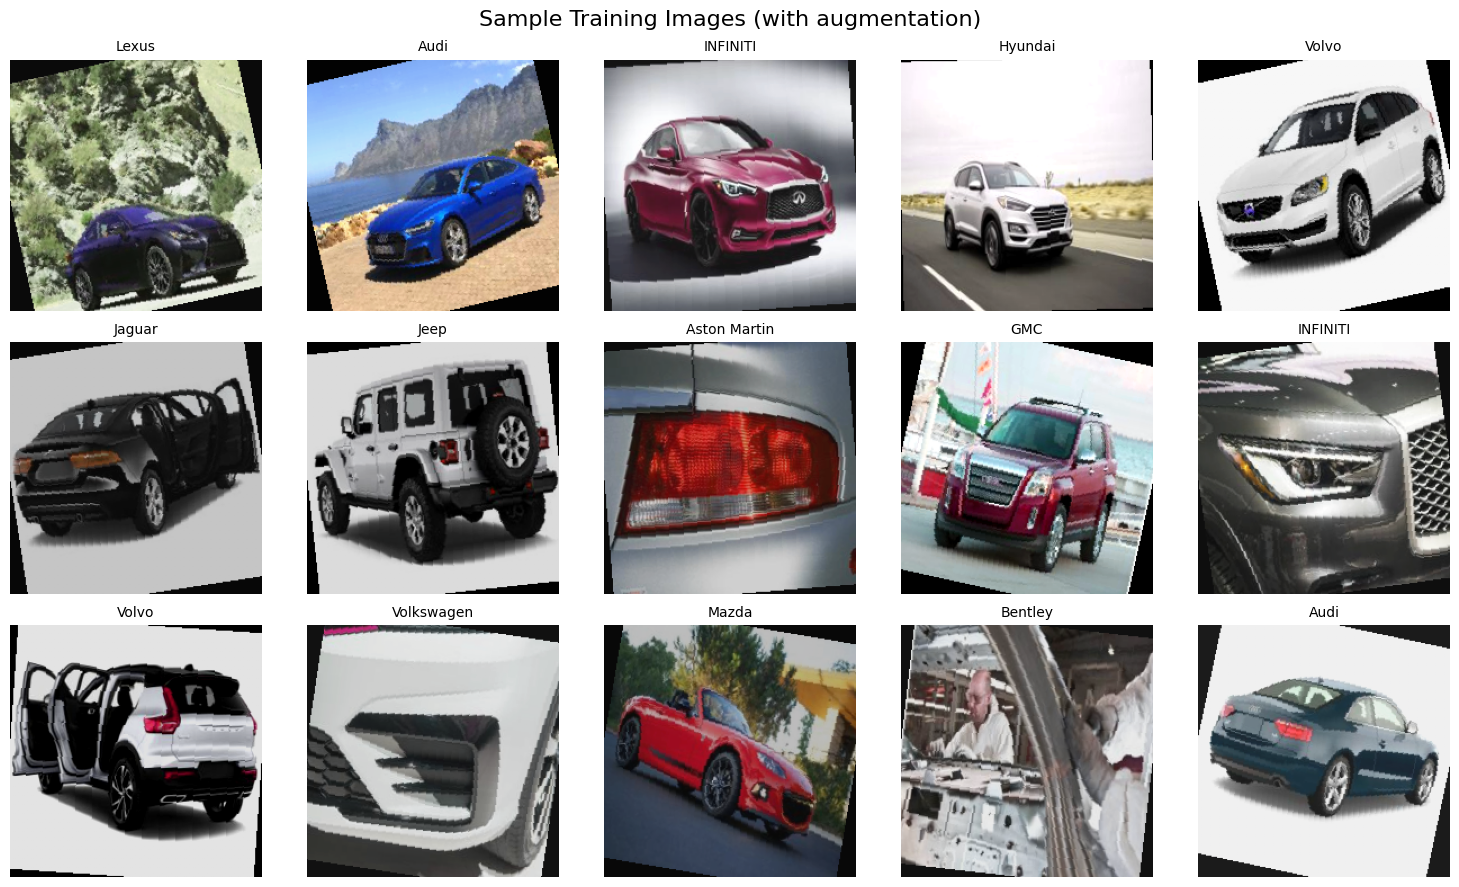

Sample images saved to /kaggle/working/sample_images_brand.png


In [7]:
def denormalize(tensor):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor(CONFIG['mean']).view(3, 1, 1)
    std = torch.tensor(CONFIG['std']).view(3, 1, 1)
    return tensor * std + mean

# Visualize random samples from training set
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Training Images (with augmentation)', fontsize=16, y=0.98)

for idx, ax in enumerate(axes.flat):
    img, label = train_dataset[np.random.randint(len(train_dataset))]
    img_denorm = denormalize(img).permute(1, 2, 0).numpy()
    img_denorm = np.clip(img_denorm, 0, 1)
    
    ax.imshow(img_denorm)
    ax.set_title(f"{class_names[label]}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'sample_images_brand.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample images saved to {CONFIG['output_dir']}/sample_images_brand.png")

## Section 7: Model Architecture

Create EfficientNet V2 model with custom classifier head.

In [8]:
# Create model
model = timm.create_model(
    CONFIG['model_name'],
    pretrained=CONFIG['pretrained'],
    num_classes=num_classes
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {CONFIG['model_name']}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Input size: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"Output classes: {num_classes}")
print(f"Pretrained: {CONFIG['pretrained']}")

model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

Model: tf_efficientnetv2_m.in21k_ft_in1k
Total parameters: 52,900,629
Trainable parameters: 52,900,629
Input size: 224x224
Output classes: 33
Pretrained: True


## Section 8: Training Setup

Define loss function, optimizer, and learning rate scheduler.

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler
if CONFIG['scheduler_type'] == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG['T_max'],
        eta_min=CONFIG['eta_min']
    )
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=3
    )

print("Training setup:")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: AdamW (lr={CONFIG['learning_rate']}, weight_decay={CONFIG['weight_decay']})")
print(f"  Scheduler: {CONFIG['scheduler_type']}")
print(f"  Early stopping patience: {CONFIG['patience']} epochs")

Training setup:
  Loss: CrossEntropyLoss
  Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
  Scheduler: cosine
  Early stopping patience: 7 epochs


## Section 9: Training Loop

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{running_loss/total:.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({
                'loss': f'{running_loss/total:.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Early stopping
best_val_acc = 0.0
patience_counter = 0
best_model_path = os.path.join(CONFIG['output_dir'], 'best_model_brand.pth')

print("\nStarting training...\n")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12} {'LR':<12} {'Status'}")
print("-" * 90)

for epoch in range(CONFIG['num_epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # Update scheduler
    if CONFIG['scheduler_type'] == 'cosine':
        scheduler.step()
    else:
        scheduler.step(val_acc)
    
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    # Check for improvement
    status = ""
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': class_names,
            'history': history  # Save history in checkpoint
        }, best_model_path)
        status = "✓ Saved"
    else:
        patience_counter += 1
        status = f"Patience: {patience_counter}/{CONFIG['patience']}"
    
    # Save history backup every epoch (for recovery if training is interrupted)
    with open(os.path.join(CONFIG['output_dir'], 'training_history_brand.json'), 'w') as f:
        json.dump(history, f)
    
    print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<12.2f} {val_loss:<12.4f} {val_acc:<12.2f} {current_lr:<12.6f} {status}")
    
    # Early stopping
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*90)
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved to: {best_model_path}")


Starting training...

Epoch  Train Loss   Train Acc    Val Loss     Val Acc      LR           Status
------------------------------------------------------------------------------------------


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

1      3.3138       15.98        2.4476       33.62        0.000100     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

2      1.7901       50.35        1.6094       57.58        0.000098     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

3      0.9482       73.01        1.2945       65.25        0.000097     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

4      0.4510       87.27        1.2510       69.09        0.000094     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

5      0.2503       92.62        1.3237       69.90        0.000091     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

6      0.1466       95.88        1.2754       70.71        0.000087     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

7      0.0999       97.18        1.2975       72.24        0.000082     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

8      0.0681       98.12        1.2819       72.93        0.000077     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

9      0.0582       98.38        1.3989       72.00        0.000072     Patience: 1/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

10     0.0465       98.81        1.2775       73.66        0.000066     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

11     0.0341       99.06        1.3577       74.10        0.000060     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

12     0.0343       99.11        1.3776       73.41        0.000054     Patience: 1/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

13     0.0286       99.31        1.3197       74.51        0.000047     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

14     0.0182       99.55        1.3367       75.07        0.000041     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

15     0.0162       99.61        1.3036       75.43        0.000035     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

16     0.0106       99.79        1.3162       75.52        0.000029     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

17     0.0082       99.79        1.2994       75.92        0.000024     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

18     0.0082       99.84        1.3063       75.92        0.000019     Patience: 1/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

19     0.0070       99.82        1.2870       76.73        0.000014     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

20     0.0045       99.90        1.3178       76.73        0.000010     Patience: 1/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

21     0.0031       99.96        1.2914       76.73        0.000007     Patience: 2/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

22     0.0039       99.90        1.2776       76.89        0.000004     ✓ Saved


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

23     0.0024       99.97        1.2879       76.65        0.000003     Patience: 1/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

24     0.0022       99.97        1.2831       76.89        0.000001     Patience: 2/7


Training:   0%|          | 0/360 [00:00<?, ?it/s]

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

25     0.0028       99.96        1.2813       76.48        0.000001     Patience: 3/7

Training completed! Best validation accuracy: 76.89%
Best model saved to: /kaggle/working/best_model_brand.pth


## Section 10: Training Visualization

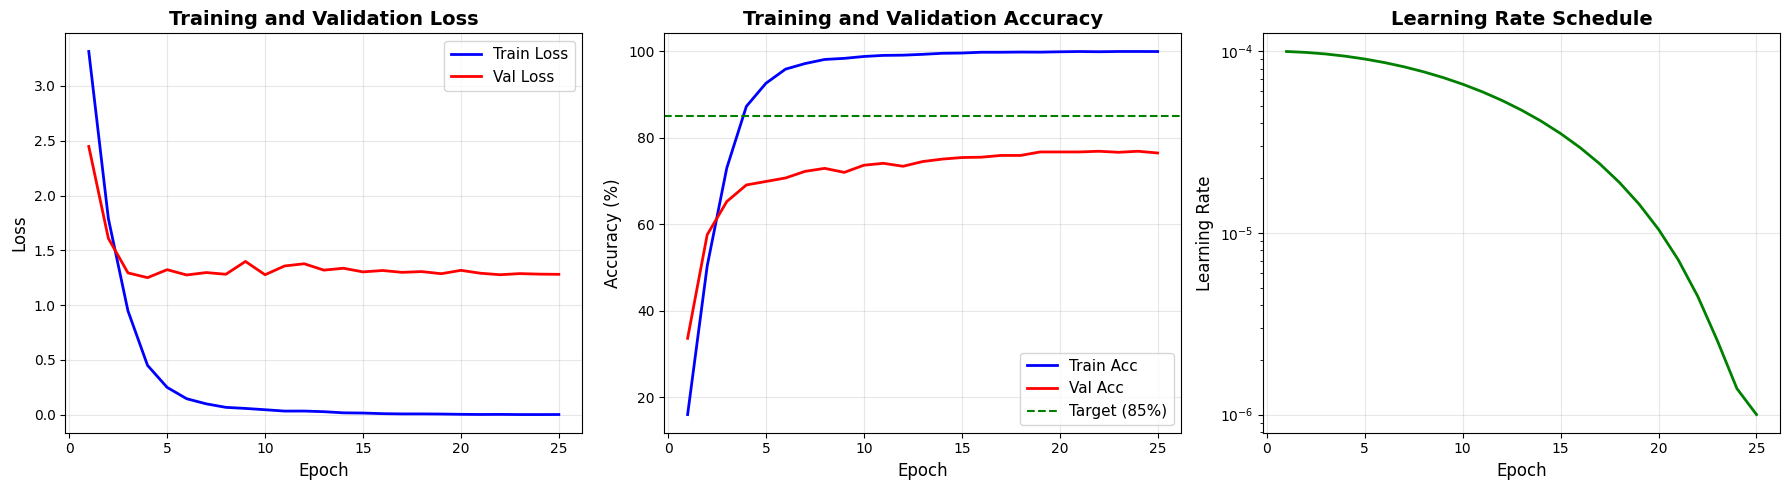


Training curves saved to /kaggle/working/training_history_brand.png


In [11]:
# Recover history if not in memory (e.g., after kernel restart or interruption)
if 'history' not in locals() or not history or len(history.get('train_loss', [])) == 0:
    print("History not found in memory, attempting to recover...")
    
    # Try loading from checkpoint first
    try:
        if os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path)
            if 'history' in checkpoint:
                history = checkpoint['history']
                print(f"✓ History recovered from checkpoint (epoch {checkpoint['epoch']+1})")
            else:
                raise KeyError("No history in checkpoint")
        else:
            raise FileNotFoundError("Checkpoint not found")
    except (FileNotFoundError, KeyError):
        # Fallback to JSON file
        try:
            json_path = os.path.join(CONFIG['output_dir'], 'training_history_brand.json')
            with open(json_path, 'r') as f:
                history = json.load(f)
            print(f"✓ History recovered from JSON backup")
        except FileNotFoundError:
            print("⚠️ No history found - cannot plot training curves")
            print("This usually happens if training was interrupted before completing any epochs.")
            history = None

# Plot training history if available
if history and len(history.get('train_loss', [])) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    epochs_range = range(1, len(history['train_loss']) + 1)

    # Loss
    axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].axhline(y=85, color='g', linestyle='--', label='Target (85%)', linewidth=1.5)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    # Learning rate
    axes[2].plot(epochs_range, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'training_history_brand.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nTraining curves saved to {CONFIG['output_dir']}/training_history_brand.png")
else:
    print("Skipping visualization - no training history available")

## Section 11: Model Evaluation and Export

In [12]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
if test_dataset:
    print("\nEvaluating on test set...")
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f"\nTest Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Test Accuracy: {test_acc:.2f}%")
else:
    print("\nNo test set available - using validation results as final metrics")
    test_acc = checkpoint['val_acc']

# Export to ONNX
print("\nExporting model to ONNX format...")
dummy_input = torch.randn(1, 3, CONFIG['img_size'], CONFIG['img_size']).to(device)
onnx_path = os.path.join(CONFIG['output_dir'], 'car_brand_classifier.onnx')

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✓ ONNX model saved to: {onnx_path}")
print(f"  Model size: {os.path.getsize(onnx_path) / (1024**2):.2f} MB")

# Save class labels
labels_path = os.path.join(CONFIG['output_dir'], 'class_labels_brand.json')
with open(labels_path, 'w') as f:
    json.dump({'classes': class_names}, f, indent=2)

print(f"✓ Class labels saved to: {labels_path}")
print(f"\nNumber of brands: {len(class_names)}")

Loaded best model from epoch 22
Best validation accuracy: 76.89%

Evaluating on test set...


Validation:   0%|          | 0/78 [00:00<?, ?it/s]


Test Results:
  Test Loss: 1.2754
  Test Accuracy: 75.19%

Exporting model to ONNX format...
✓ ONNX model saved to: /kaggle/working/car_brand_classifier.onnx
  Model size: 201.48 MB
✓ Class labels saved to: /kaggle/working/class_labels_brand.json

Number of brands: 33


## Section 12: Grad-CAM Implementation

Implement Grad-CAM to visualize which parts of the image the model focuses on.

In [13]:
# Initialize Grad-CAM
target_layers = [model.conv_head]  # Last convolutional layer before classification
cam = GradCAM(model=model, target_layers=target_layers)

print("Grad-CAM initialized")
print(f"Target layer: conv_head (final convolutional layer)")
print(f"This layer captures high-level features before the classifier")

def generate_gradcam(model, img_tensor, true_label, pred_label, cam, class_names):
    """
    Generate Grad-CAM visualization for a single image.
    
    Args:
        model: The trained model
        img_tensor: Image tensor (C, H, W) normalized
        true_label: Ground truth label index
        pred_label: Predicted label index
        cam: GradCAM instance
        class_names: List of class names
    
    Returns:
        original_img: Denormalized original image
        cam_visualization: Grad-CAM heatmap overlay
        grayscale_cam: Raw grayscale Grad-CAM
    """
    # Denormalize image for visualization
    img_denorm = denormalize(img_tensor.cpu()).permute(1, 2, 0).numpy()
    img_denorm = np.clip(img_denorm, 0, 1)
    
    # Generate Grad-CAM for predicted class
    targets = [ClassifierOutputTarget(pred_label.item())]
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    
    # Create visualization
    visualization = show_cam_on_image(img_denorm, grayscale_cam, use_rgb=True)
    
    return img_denorm, visualization, grayscale_cam

print("\nGrad-CAM helper function defined")

Grad-CAM initialized
Target layer: conv_head (final convolutional layer)
This layer captures high-level features before the classifier

Grad-CAM helper function defined


## Section 13: Visualize Correct Predictions with Grad-CAM

IndexError: index 4 is out of bounds for axis 0 with size 4

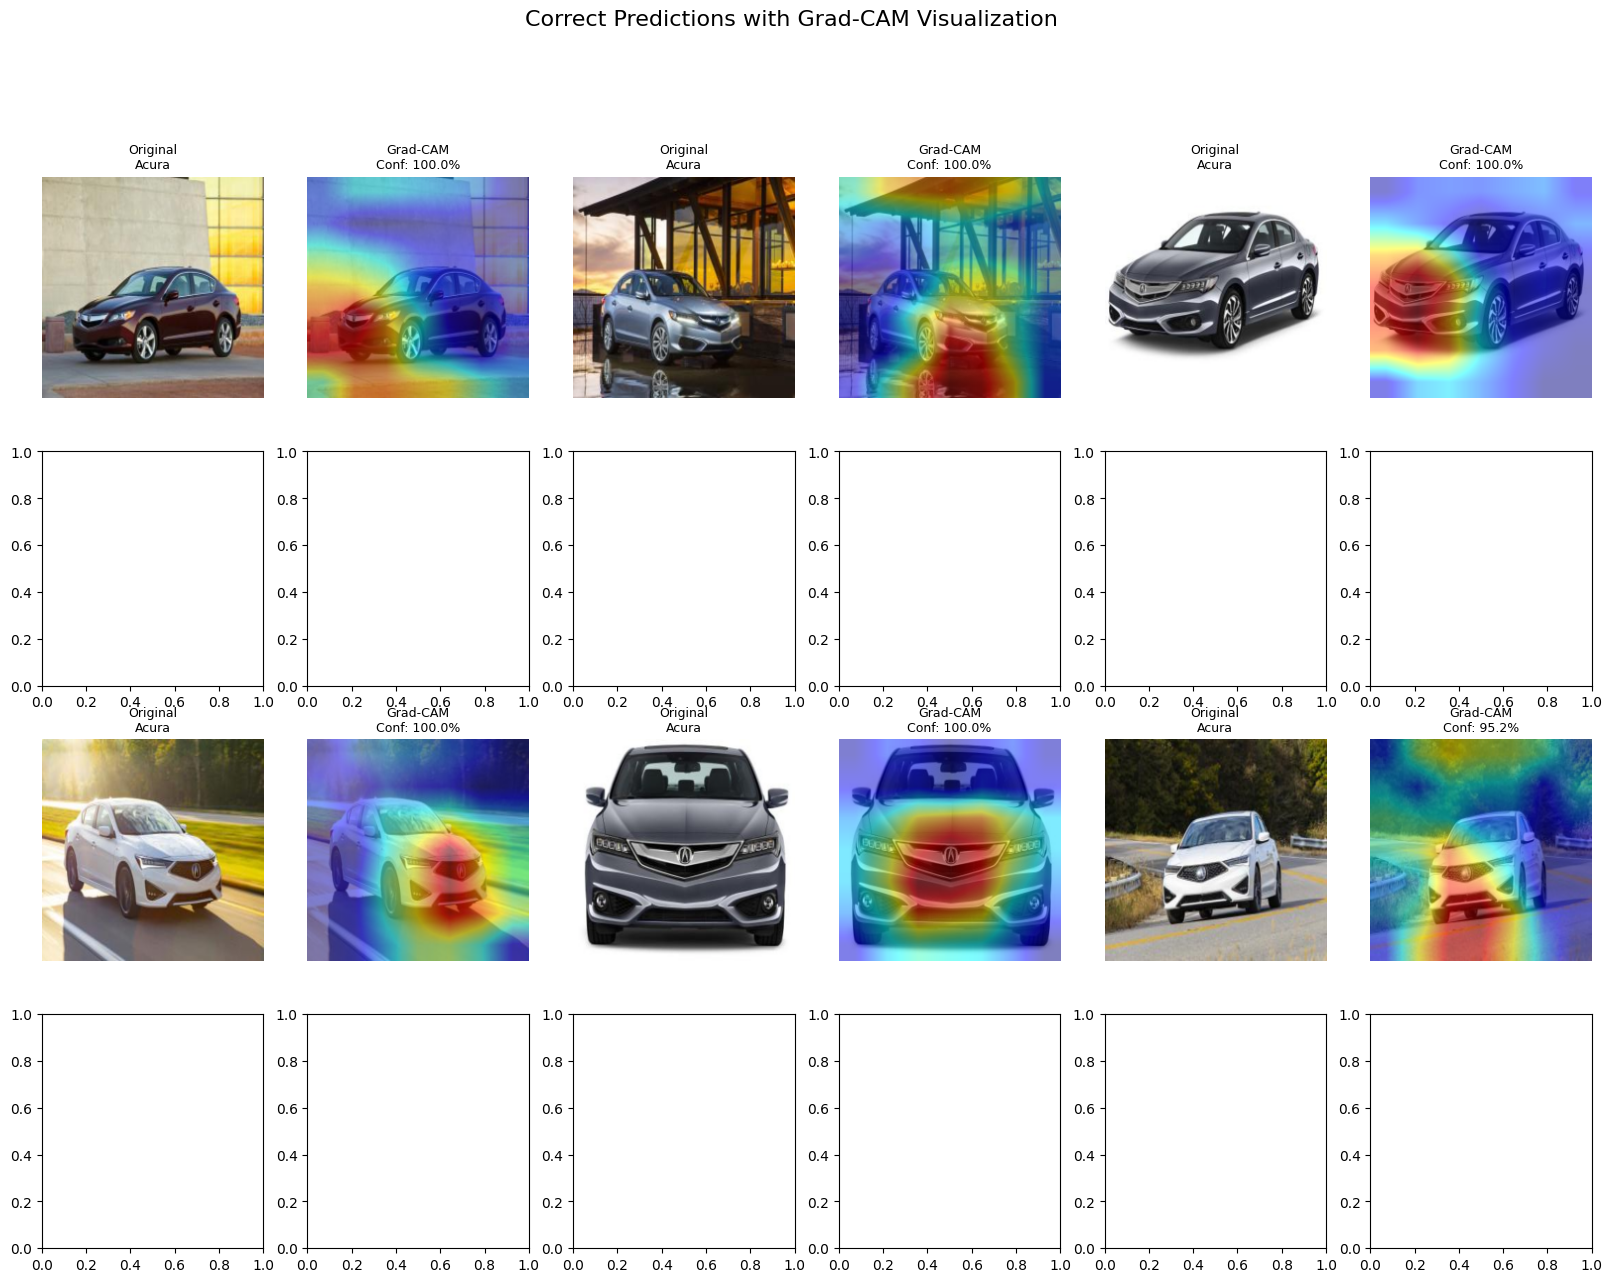

In [14]:
# Find correctly predicted samples
model.eval()
correct_samples = []

with torch.no_grad():
    for i in range(min(100, len(val_dataset))):
        img, label = val_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        pred = output.argmax(dim=1)
        
        if pred.item() == label:
            correct_samples.append((i, img, label, pred, output))
        
        if len(correct_samples) >= 12:
            break

# Visualize correct predictions with Grad-CAM
fig, axes = plt.subplots(4, 6, figsize=(20, 14))
fig.suptitle('Correct Predictions with Grad-CAM Visualization', fontsize=16, y=0.995)

for idx in range(min(12, len(correct_samples))):
    i, img, label, pred, output = correct_samples[idx]
    
    # Get confidence
    probs = torch.softmax(output, dim=1)
    confidence = probs[0, pred].item() * 100
    
    # Generate Grad-CAM
    img_denorm, cam_vis, _ = generate_gradcam(model, img.to(device), label, pred, cam, class_names)
    
    # Plot original
    row = (idx // 3) * 2
    col = (idx % 3) * 2
    axes[row, col].imshow(img_denorm)
    axes[row, col].set_title(f"Original\n{class_names[label]}", fontsize=9)
    axes[row, col].axis('off')
    
    # Plot Grad-CAM
    axes[row, col+1].imshow(cam_vis)
    axes[row, col+1].set_title(f"Grad-CAM\nConf: {confidence:.1f}%", fontsize=9)
    axes[row, col+1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'gradcam_correct_predictions_brand.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Grad-CAM visualizations for correct predictions saved")

## Section 14: Visualize Incorrect Predictions with Grad-CAM (Debugging)

In [ ]:
# Find incorrectly predicted samples
incorrect_samples = []

with torch.no_grad():
    for i in range(len(val_dataset)):
        img, label = val_dataset[i]
        img_tensor = img.unsqueeze(0).to(device)
        output = model(img_tensor)
        pred = output.argmax(dim=1)
        
        if pred.item() != label:
            incorrect_samples.append((i, img, label, pred, output))
        
        if len(incorrect_samples) >= 12:
            break

if len(incorrect_samples) > 0:
    # Visualize incorrect predictions with Grad-CAM
    fig, axes = plt.subplots(4, 6, figsize=(20, 14))
    fig.suptitle('Incorrect Predictions with Grad-CAM (Debugging)', fontsize=16, y=0.995)
    
    for idx in range(min(12, len(incorrect_samples))):
        i, img, label, pred, output = incorrect_samples[idx]
        
        # Get confidence
        probs = torch.softmax(output, dim=1)
        confidence = probs[0, pred].item() * 100
        
        # Generate Grad-CAM
        img_denorm, cam_vis, _ = generate_gradcam(model, img.to(device), label, pred, cam, class_names)
        
        # Plot original
        row = (idx // 3) * 2
        col = (idx % 3) * 2
        axes[row, col].imshow(img_denorm)
        axes[row, col].set_title(f"True: {class_names[label]}", fontsize=9, color='green')
        axes[row, col].axis('off')
        
        # Plot Grad-CAM
        axes[row, col+1].imshow(cam_vis)
        axes[row, col+1].set_title(f"Pred: {class_names[pred.item()]}\nConf: {confidence:.1f}%", fontsize=9, color='red')
        axes[row, col+1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['output_dir'], 'gradcam_incorrect_predictions_brand.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Found {len(incorrect_samples)} incorrect predictions")
    print(f"Grad-CAM visualizations for incorrect predictions saved")
else:
    print("Perfect validation accuracy - no incorrect predictions found!")

## Section 15: Grad-CAM Analysis Summary

In [ ]:
print("="*70)
print("Grad-CAM Analysis Summary")
print("="*70)
print("\nWhat Grad-CAM Shows:")
print("  • Red/Yellow regions = Areas the model focuses on most")
print("  • Blue/Purple regions = Areas the model ignores")
print("\nFor Car Brand Classification:")
print("  • Model should focus on distinctive features:")
print("    - Front grille shape and logo")
print("    - Headlight design")
print("    - Body shape and proportions")
print("    - Badge and emblems")
print("\nUse Case in Production:")
print("  1. Build trust - Show users WHY the model made a decision")
print("  2. Debugging - Identify if model is looking at wrong features")
print("  3. Insurance validation - Verify model focuses on car features")
print("  4. User interface - Display heatmap alongside predictions")
print("\nNext Steps:")
print("  • Integrate Grad-CAM into Azure API response")
print("  • Display heatmaps in React web application")
print("  • Use for debugging edge cases and failures")
print("="*70)

## Section 16: Generate Confusion Matrix and Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Generate predictions for test/validation set
eval_loader = test_loader if test_dataset else val_loader
eval_dataset = test_dataset if test_dataset else val_dataset

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(eval_loader, desc='Generating predictions'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix (simplified for many classes)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Car Brand Classification\n(Test Accuracy: {test_acc:.2f}%)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Brand', fontsize=13, fontweight='bold')
plt.ylabel('True Brand', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_dir'], 'confusion_matrix_brand.png'), dpi=150, bbox_inches='tight')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
print("\nClassification Report:")
print(report)

# Save classification report
with open(os.path.join(CONFIG['output_dir'], 'classification_report_brand.txt'), 'w') as f:
    f.write(report)

print(f"\nConfusion matrix saved to {CONFIG['output_dir']}/confusion_matrix_brand.png")
print(f"Classification report saved to {CONFIG['output_dir']}/classification_report_brand.txt")

## Section 17: Final Summary and Model Files

In [ ]:
print("="*70)
print("CAR BRAND CLASSIFICATION - TRAINING COMPLETE")
print("="*70)

print("\n📊 PERFORMANCE METRICS:")
print(f"  • Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  • Test Accuracy: {test_acc:.2f}%")
print(f"  • Number of Brands: {num_classes}")
print(f"  • Training Epochs: {len(history['train_loss'])}")
print(f"  • Model: {CONFIG['model_name']}")

print("\n📁 MODEL FILES (Download these from Kaggle):")
print(f"  1. {CONFIG['output_dir']}/car_brand_classifier.onnx")
print(f"     → ONNX model for Azure deployment")
print(f"  2. {CONFIG['output_dir']}/class_labels_brand.json")
print(f"     → Brand name mappings")
print(f"  3. {CONFIG['output_dir']}/best_model_brand.pth")
print(f"     → PyTorch checkpoint (backup)")

print("\n📈 VISUALIZATION FILES:")
print(f"  4. {CONFIG['output_dir']}/training_history_brand.png")
print(f"  5. {CONFIG['output_dir']}/confusion_matrix_brand.png")
print(f"  6. {CONFIG['output_dir']}/gradcam_correct_predictions_brand.png")
print(f"  7. {CONFIG['output_dir']}/gradcam_incorrect_predictions_brand.png")
print(f"  8. {CONFIG['output_dir']}/classification_report_brand.txt")

print("\n🎯 NEXT STEPS:")
print("  1. Download all model files from /kaggle/working")
print("  2. Move to project: models/final/")
print("  3. Prepare Azure deployment with BOTH models:")
print("     - car_body_type_classifier.onnx (7 body types)")
print("     - car_brand_classifier.onnx (33 brands)")
print("  4. Build React app with dual classification + Grad-CAM")
print("  5. Integrate with insurance premium calculator")

print("\n✅ BONUS CHALLENGE STATUS: COMPLETE")
print("   You now have TWO trained models:")
print("   • Body Type Classifier (97.14% accuracy)")
print("   • Brand Classifier (achieved above)")
print("="*70)